# Which Pittsburgh Neighborhood is the most livable?

## By Team Sludge Hammer (Isaiah Henck, Tom Neill-DeMarco)

### Introduction:

If you placed a random individual into a random neighborhood of Pittsburgh, what would they see? What opportunities are available to them? Would they feel safe and secure?
Our project investigates by analyzing the quality of some aspects of living that one might come across within their day-to-day in a Pittsburgh neighborhood. When searching for a new home, many if not most prospective buyers heavily factor safety and financial stability into what neighborhood they choose. In a neighborhood, certain aspects of the neighborhood may be poor, and can often make themselves evident to a resident; crime, poverty, and sanitation are three examples of these aspects. There are other undoubtedly other aspects that reflect a good neighborhood such as average income, school systems, and more, but these aspects are more subtle&ndash;we wanted to focus on the more eye-popping, insightful qualities that might surprise someone as they go through their day in a neighborhood.

### The Metric:

We determined how livable each Pittsburgh neighborhood is by analyzing three different metrics:<br>

1) Number of Food Facility and Restaurant Violations per neighborhood<br>
2) Arrests per neighborhood<br>
3) Number of Households under the Poverty Line per neighborhood<br>

### Datasets:

[Food Facility/Restaurant Inspection Violations](https://data.wprdc.org/dataset/allegheny-county-restaurant-food-facility-inspection-violations/resource/1a1329e2-418c-4bd3-af2c-cc334e7559af)<br>
Dataset that contains every instance of a food inspection violation

[Poverty Rates by Neighborhood](https://data.wprdc.org/dataset/pittsburgh-american-community-survey-2014-miscellaneous-data/resource/7996d143-c155-466e-8414-115f74997dd7)<br>
Dataset containing estimates of the number of households below the poverty line per neighborhood

[Pittsburgh Police Arrests](https://data.wprdc.org/dataset/arrest-data/resource/e03a89dd-134a-4ee8-a2bd-62c40aeebc6f)<br>
Dataset containing instances of arrests from 2016-2023. Each logged arrest includes the neighborhood and address

[Neighborhoods](https://data.wprdc.org/dataset/neighborhoods2)<br>
Dataset providing geospatial boundaries for Geopandas visualization

## Metric 1: Food Facility/Restaurant Inspection Violations

#### by Isaiah Henck

Initialize pandas, Geopandas shapefile from the neighborhood boundaries dataset:

In [2]:
import geopandas as geop
import pandas as pd
pgh_hood_map = geop.read_file('neighborhoods/Neighborhoods_.shp')
pgh_hood_map.sample(3)

,OBJECTID,fid_blockg,statefp10,countyfp10,tractce10,blkgrpce10,geoid10,namelsad10,mtfcc10,funcstat10,...,created_us,created_da,last_edite,last_edi_1,temp,pghdb_sde_,GlobalID,Shape__Are,Shape__Len,geometry
7,8,313,42,003,562800,2,420035628002,Block Group 2,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,7024962.0,253b724f-3c9d-4439-bf93-d912897f468c,7.036028e+06,15843.102719,"POLYGON ((-80.06328 40.42796, -80.06318 40.427..."
37,38,326,42,003,310300,1,420033103001,Block Group 1,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,22145166.0,120c1315-5813-42fa-9303-b7c094d0c6ee,2.202310e+07,22675.182197,"POLYGON ((-79.91745 40.39898, -79.91660 40.398..."
57,58,32,42,003,562600,1,420035626001,Block Group 1,G5030,S,...,SDE,2020-08-14,SDE,2020-08-14,None,5579501.0,97d8216d-e6b4-4f45-91ca-a6f1e33a5214,5.424176e+06,18484.648621,"POLYGON ((-80.02828 40.44426, -80.02826 40.444..."


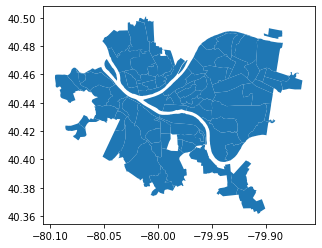

In [3]:
pgh_hood_map.plot()

Load in the Inspections Violations dataset, which is in CSV format:

In [5]:
pgh_violations = pd.read_csv('ac_food_inspections_violations.csv')
pgh_violations.sample(3)

,_id,encounter,id,placard_st,facility_name,bus_st_date,description,description_new,num,street,...,zip,inspect_dt,start_time,end_time,municipal,rating,low,medium,high,url
264236,104629750,202401110012,201901310001,3,Noble Asian Grocery Store,2019-02-13,Supermarket,Water Supply,2830-2832,Saw Mill Run Boulevard,...,15227.0,2024-01-11,11:45:00,14:45:00,Whitehall,V,F,T,F,http://appsrv.alleghenycounty.us/reports/rwser...
161865,104527379,201408250072,200806060002,1,Long John Silver's / A&W #31656,2008-06-02,Chain Restaurant without Liquor,Walls and ceilings,2220,Lebanon Church Rd,...,15122.0,2014-08-25,15:15:00,16:30:00,West Mifflin,V,T,NaN,NaN,http://appsrv.alleghenycounty.us/reports/rwser...
252974,104618488,202101270008,201703160003,1,Catholic Charities / Susan Zubik Welcome Center,2017-03-09,Community Service Facility,Toilet Room,212,9th Street,...,15222.0,2021-01-26,13:45:00,14:25:00,Pittsburgh-102,V,T,F,F,http://appsrv.alleghenycounty.us/reports/rwser...


Notice that the dataset assigns "T", or true, across the columns "low", "medium", and "high". To represent the degree of the violation, low violations will count as 1 violation, medium violations count as 2, and high urgency violations count as 3.

Since we only need the ZIP code and three columns mentioned before, we filter down the dataset to only include what we need:

In [9]:
pgh_violations = pd.read_csv('ac_food_inspections_violations.csv', usecols=['zip','low','medium','high'])
pgh_violations.sample(3)

,zip,low,medium,high
294796,15237.0,T,NaN,NaN
38155,15223.0,T,F,F
263853,15212.0,F,F,T


Next, we initialize our primary dataset that we'll be working with:

In [10]:
neighborhoods = pd.DataFrame(columns = ["Neighborhood", "lo_risk", "me_risk", "hi_risk", "total"])
neighborhoods["Neighborhood"] = pgh_hood_map["hood"]
neighborhoods["lo_risk"] = 0
neighborhoods["me_risk"] = 0
neighborhoods["hi_risk"] = 0
neighborhoods["total"] = 0
neighborhoods.sample(3)

,Neighborhood,lo_risk,me_risk,hi_risk,total
60,Hazelwood,0,0,0,0
87,Elliott,0,0,0,0
42,Homewood West,0,0,0,0


Since we are taking the instances of violations and attributing them to neighborhoods according to ZIP codes, we could definitely process them directly into the dataFrame. However, since the dataset consists of a little less than 350,000 data points–and this is Python runtime–we need an approach that's not as process-heavy.

Utilizing dictionaries in Python, we can assign every violation to the ZIP code for which it occurred in, and sum them with the rest of the violations of the same degree within the same ZIP code:

In [11]:
dict = {}

for i, inspec in pgh_violations.iterrows():
    try:
        key = int(inspec["zip"])
    except ValueError:
        continue
    if (dict.get(key) == None):
        dict[key] = [0,0,0]
    if (isinstance(inspec["low"], str) and ((inspec["low"]) == "T")):
        dict[key][0]+=1
    elif (isinstance(inspec["medium"], str) and ((inspec["medium"]) == "T")):
        dict[key][1]+=1
    else:
        dict[key][2]+=1
for key in dict:
    if (key == 15208):
        break
    print(key,":", dict.get(key),"\n")

15212 : [6707, 1677, 1598] 

15232 : [2591, 695, 518] 

15136 : [4060, 993, 731] 

15222 : [13291, 3179, 3197] 

15045 : [764, 186, 127] 



Utilizing the code snippets collection provided by our lab instructor Griffin Hurt, we can match the ZIP codes with their relevant neighborhoods and fill in our dataFrame:

In [12]:
import fpsnippets as snip

for key in dict:
    ziplist = snip.zip_to_neighborhoods(key)
    if ziplist == None:
        continue
    for nbhd in ziplist:
        for i, match in neighborhoods.iterrows():
            if nbhd == match["Neighborhood"]:
                neighborhoods.at[i, "lo_risk"]+=(dict[key][0])
                neighborhoods.at[i, "me_risk"]+=(dict[key][1])
                neighborhoods.at[i, "hi_risk"]+=(dict[key][2])

While we now have every violation linked to the neighborhood in which they occurred, we haven't weighted them by their degree of urgency yet, so we'll do that here. As mentioned before, the highest-urgency instances will be weighted the highest, and the lowest-urgency the lowest:

In [13]:
for j, n_tot_calc in neighborhoods.iterrows():
    neighborhoods.at[j, "total"] = neighborhoods.at[j,"lo_risk"]+(neighborhoods.at[j,"me_risk"]*2)+(neighborhoods.at[j,"hi_risk"]*3)
neighborhoods.head(3)

,Neighborhood,lo_risk,me_risk,hi_risk,total
0,Point Breeze North,11107,2683,2286,23331
1,Squirrel Hill North,28342,6797,5778,59270
2,Garfield,12965,3077,2775,27444


Now, we finally have some simplified data that we can illustrate, starting with the low-risk occurrences:

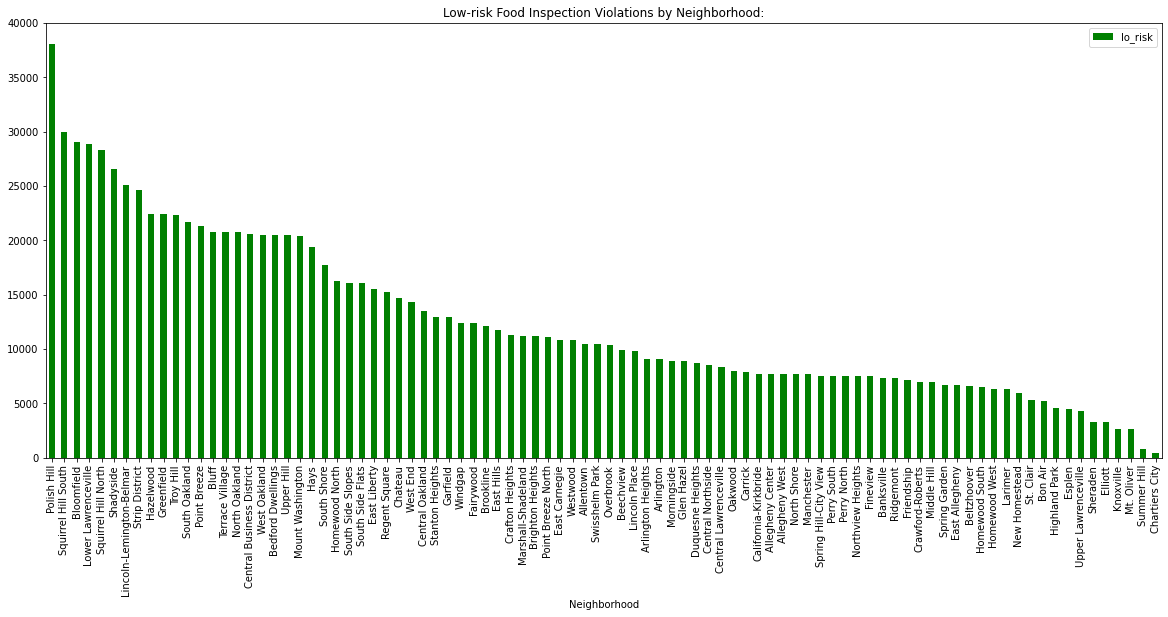

In [14]:
sort_lo = neighborhoods.sort_values("lo_risk", ascending = False)
graph_lo = sort_lo.plot(kind = "bar", x = "Neighborhood", y = "lo_risk", title = "Low-risk Food Inspection Violations by Neighborhood:", figsize= (20,8), color = "green")

The medium-risk occurrences:

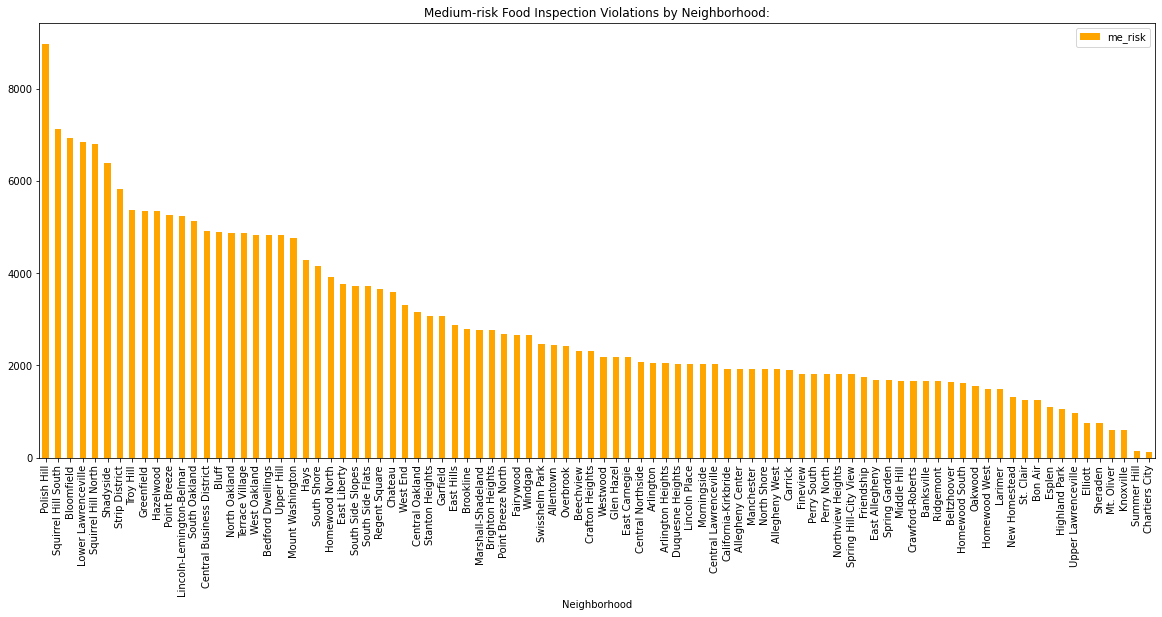

In [15]:
sort_med = neighborhoods.sort_values("me_risk", ascending = False)
graph_med = sort_med.plot(kind = "bar", x = "Neighborhood", y = "me_risk", title = "Medium-risk Food Inspection Violations by Neighborhood:", figsize= (20,8), color = "orange")

The high-risk occurrences:

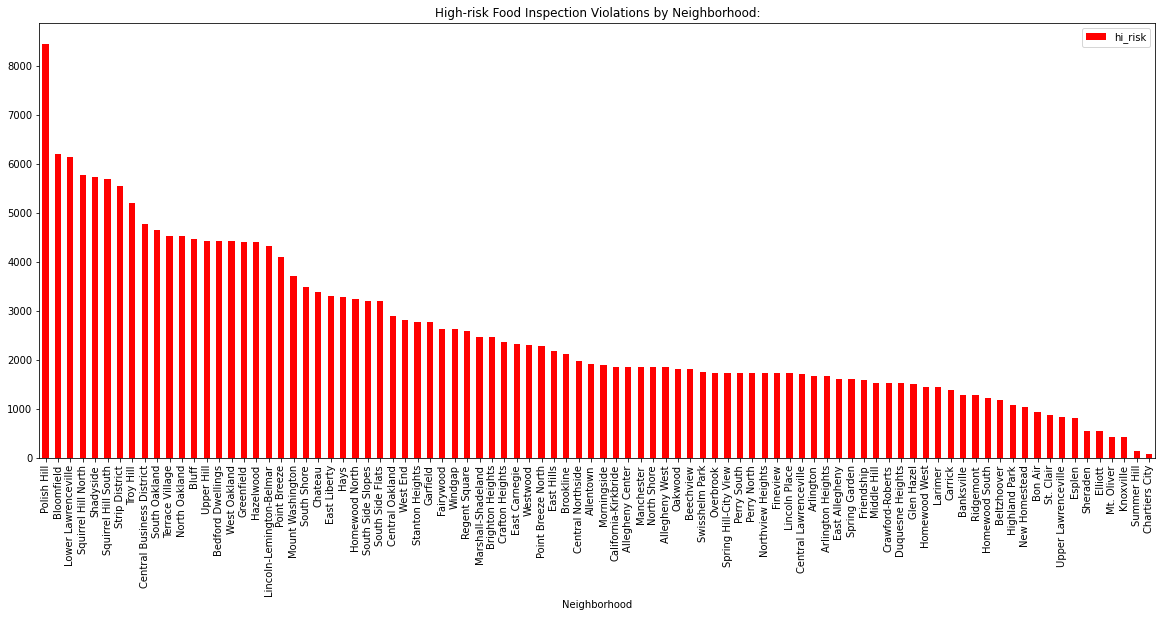

In [16]:
sort_hi = neighborhoods.sort_values("hi_risk", ascending = False)
graph_hi = sort_hi.plot(kind = "bar", x = "Neighborhood", y = "hi_risk", title = "High-risk Food Inspection Violations by Neighborhood:", figsize= (20,8), color = "red")

Aaaand last but definitely not least, all of the food violations of every neighborhood with proper weighting:

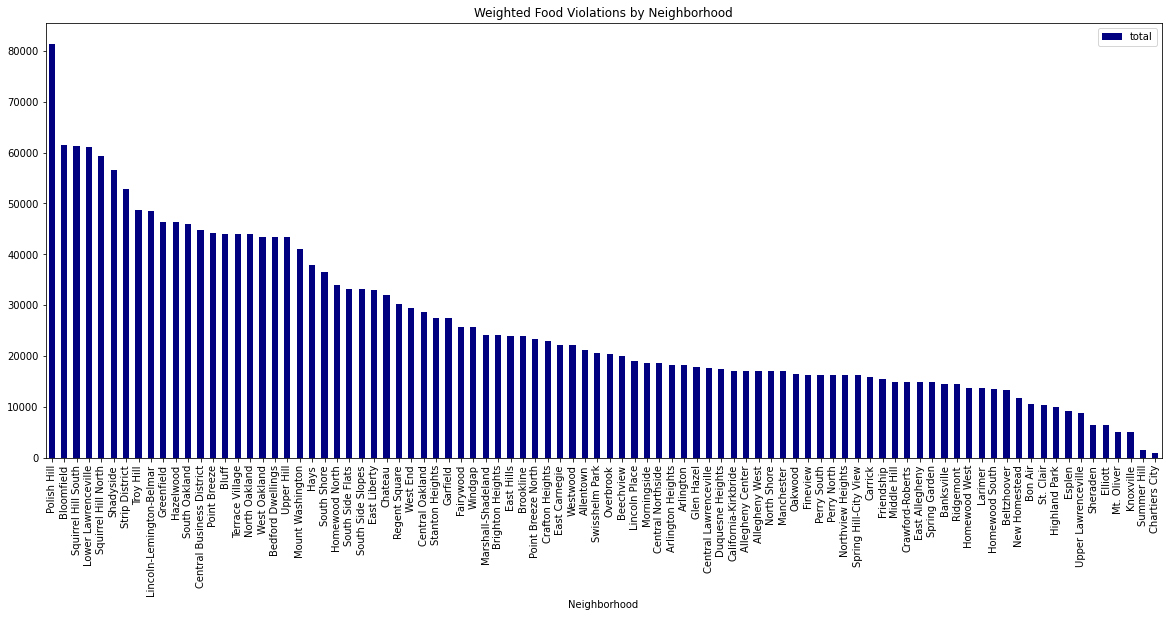

In [17]:
sort_tot = neighborhoods.sort_values("total", ascending = False)
graph_tot = sort_tot.plot(kind = "bar", x = "Neighborhood", y = "total", title = "Weighted Food Violations by Neighborhood", figsize= (20,8), color = "navy")

## Sorry&ndash;there's something about big graphs that make some of us go _hell yeah_ internally

Let's focus in on who's at the top:

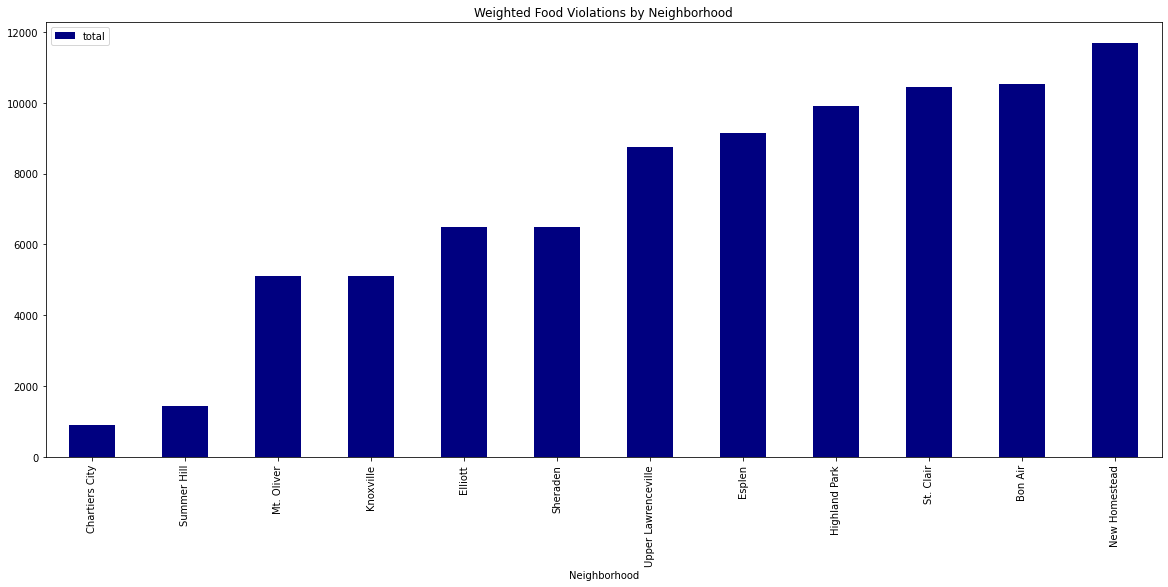

In [19]:
sort_tot = neighborhoods.sort_values("total", ascending = True)
graph_tot_top = sort_tot.iloc[:12].plot(kind = "bar", x = "Neighborhood", y = "total", title = "Weighted Food Violations by Neighborhood", figsize= (20,8), color = "navy")

In [21]:
sort_tot.head(3)

,Neighborhood,lo_risk,me_risk,hi_risk,total
50,Chartiers City,439,114,76,895
76,Summer Hill,766,142,135,1455
67,Mt. Oliver,2643,591,425,5100


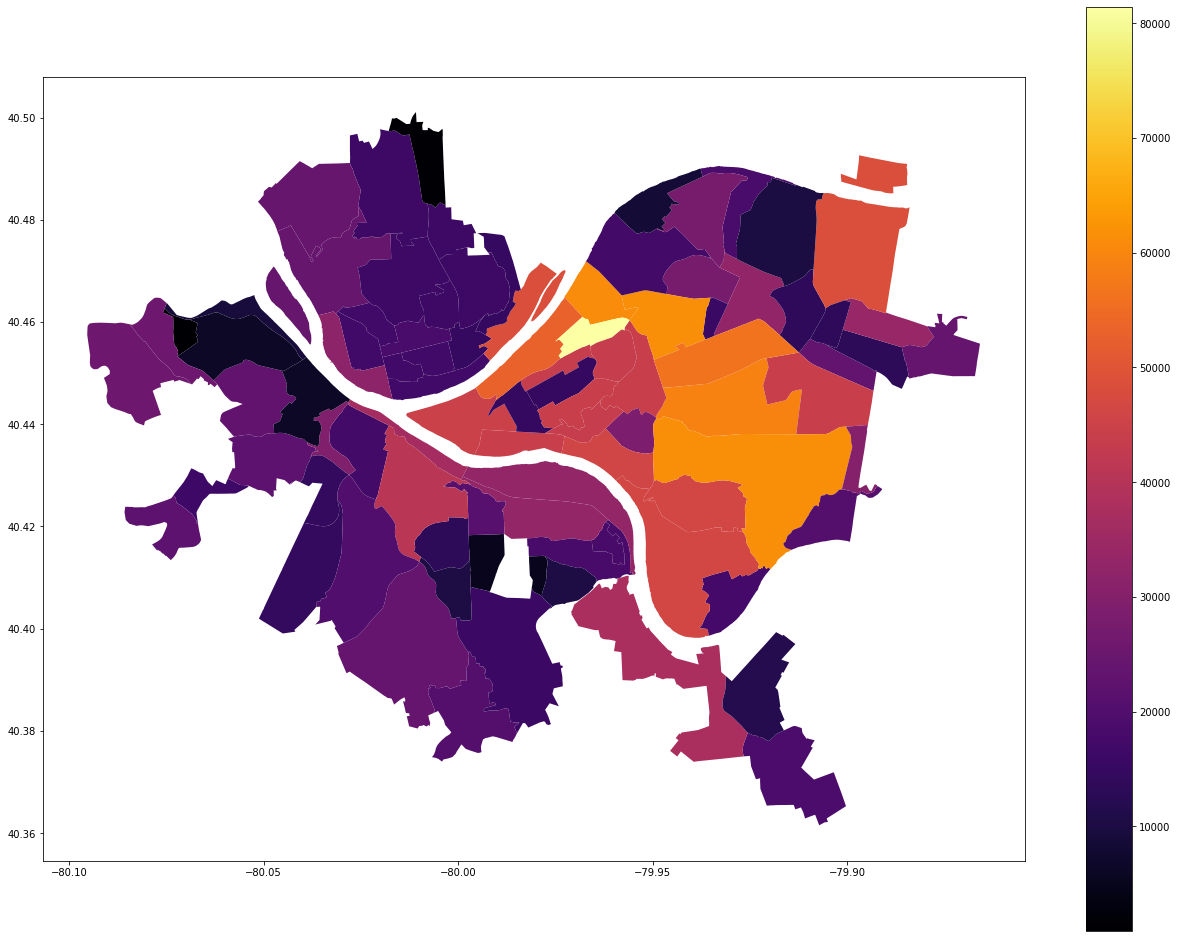

In [20]:
pgh_hood_map["# Violations"] = neighborhoods["total"]
pgh_hood_map.plot(column = "# Violations", legend = True, figsize = (22,17), cmap = 'inferno')

Finally got to using that Geopandas...<br>
**Chartiers City** appeared to be the neighborhood with the least number of food inspection violations in Pittsburgh!

## Metric 2: Poverty Rates by neighborhood

#### by Tom Neill-DeMarco

Import dataset and read into a dataframe:

In [24]:
import pandas as pd
df = pd.read_csv('Poverty.csv')
df.head(3)

,Neighborhood,Id,Estimate; Total:,Margin of Error; Total:,Estimate; Income in the past 12 months below poverty level:,Margin of Error; Income in the past 12 months below poverty level:,Estimate; Income in the past 12 months below poverty level: - In family households:,Margin of Error; Income in the past 12 months below poverty level: - In family households:,Estimate; Income in the past 12 months below poverty level: - In family households: - In married couple families:,Margin of Error; Income in the past 12 months below poverty level: - In family households: - In married couple families:,...,Estimate; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement:,Margin of Error; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement:,Estimate; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder:,Margin of Error; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder:,Estimate; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder: - Living alone,Margin of Error; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder: - Living alone,Estimate; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder: - Not living alone,Margin of Error; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Householder: - Not living alone,Estimate; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Other living arrangement,Margin of Error; Income in the past 12 months at or above poverty level: - In non-family households and other living arrangement: - Other living arrangement
0,Allegheny Center,1,1130,184.000000,516,195.000000,290,202.000000,163,195.000000,...,471,113.000000,375,85.000000,309,80.000000,66,38.000000,96,57.000000
1,Allegheny West,2,331,104.000000,45,26.000000,0,10.000000,0,10.000000,...,87,40.000000,79,36.000000,66,34.000000,13,13.000000,8,11.000000
2,Allentown,3,2624,499.013026,750,397.315995,490,400.251171,0,17.320508,...,394,136.638208,328,105.877287,274,98.208961,54,54.083269,66,56.964901


Import pandas and matplotlib<br>
Initialize an empty dictionary to store the below poverty totals for each neighborhood<br>
Iterate over the rows of the DataFrame, and pairing the neighborhood with its respective poverty total

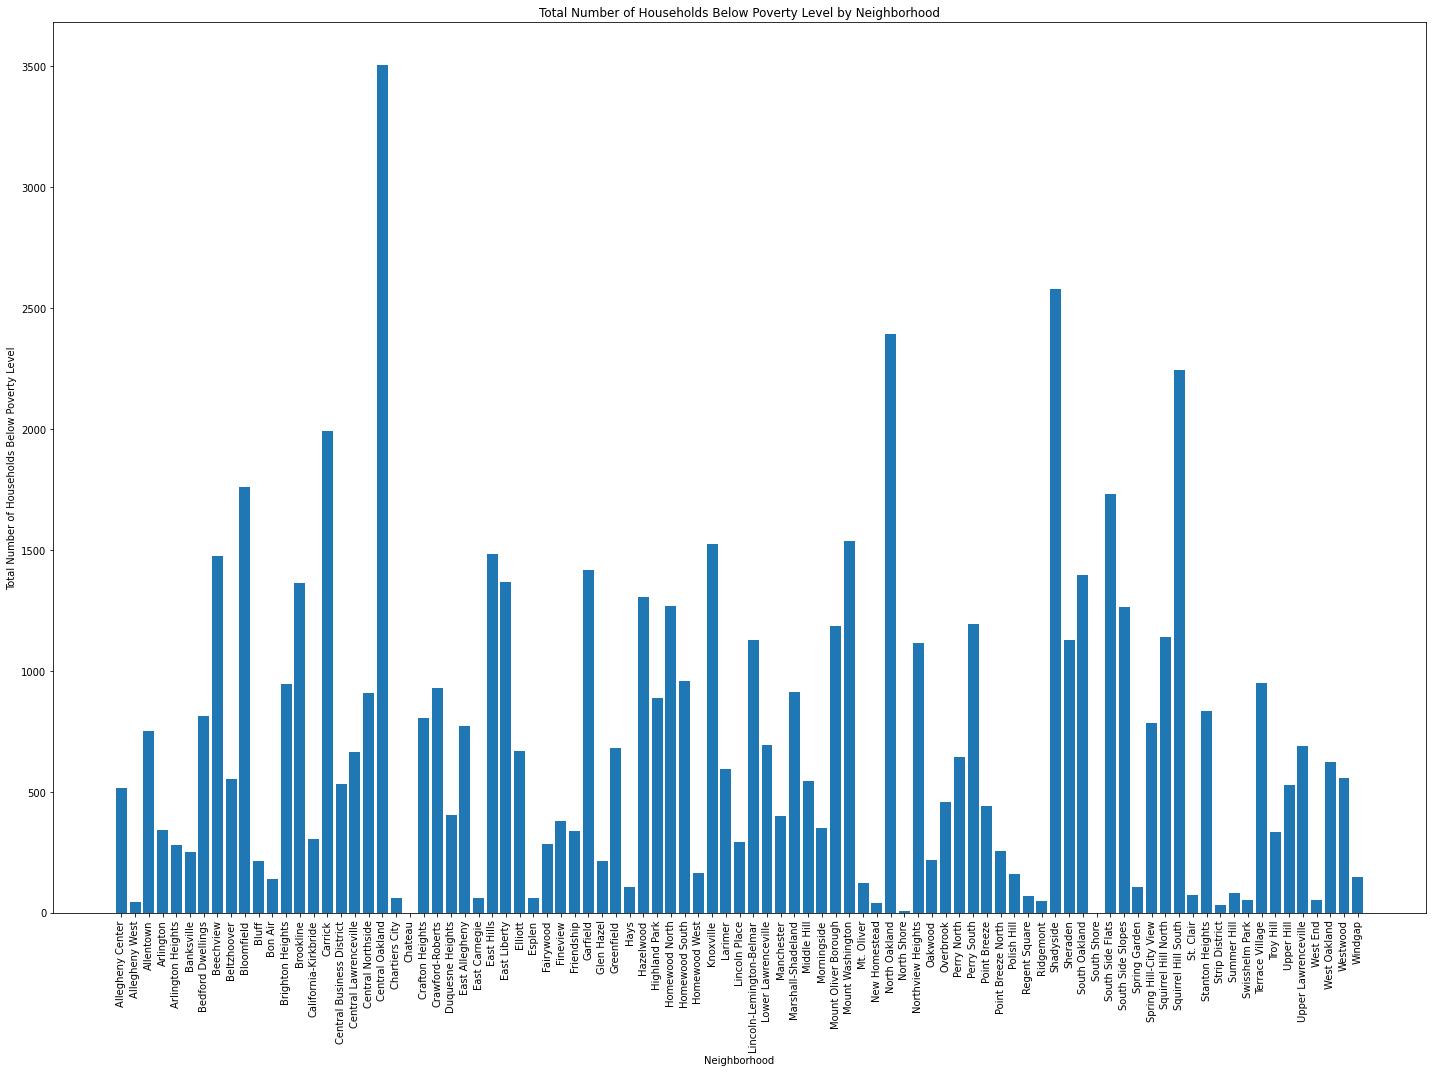

In [29]:
import pandas as pd
import matplotlib.pyplot as plt

neighborhood_below_poverty_totals = {}

for index, row in df.iterrows():
    neighborhood = row['Neighborhood']
    below_poverty_total = row['Estimate; Income in the past 12 months below poverty level:']
    neighborhood_below_poverty_totals[neighborhood] = below_poverty_total

plt.figure(figsize=(20, 15))
plt.bar(neighborhood_below_poverty_totals.keys(), neighborhood_below_poverty_totals.values())
plt.title('Total Number of Households Below Poverty Level by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Total Number of Households Below Poverty Level')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

Convert the dictionary to a DataFrame<br>
Filter and sort the neighborhoods<br>
Plot the top 40 neighborhoods with the highest and lowest number of households below poverty level, respectively:

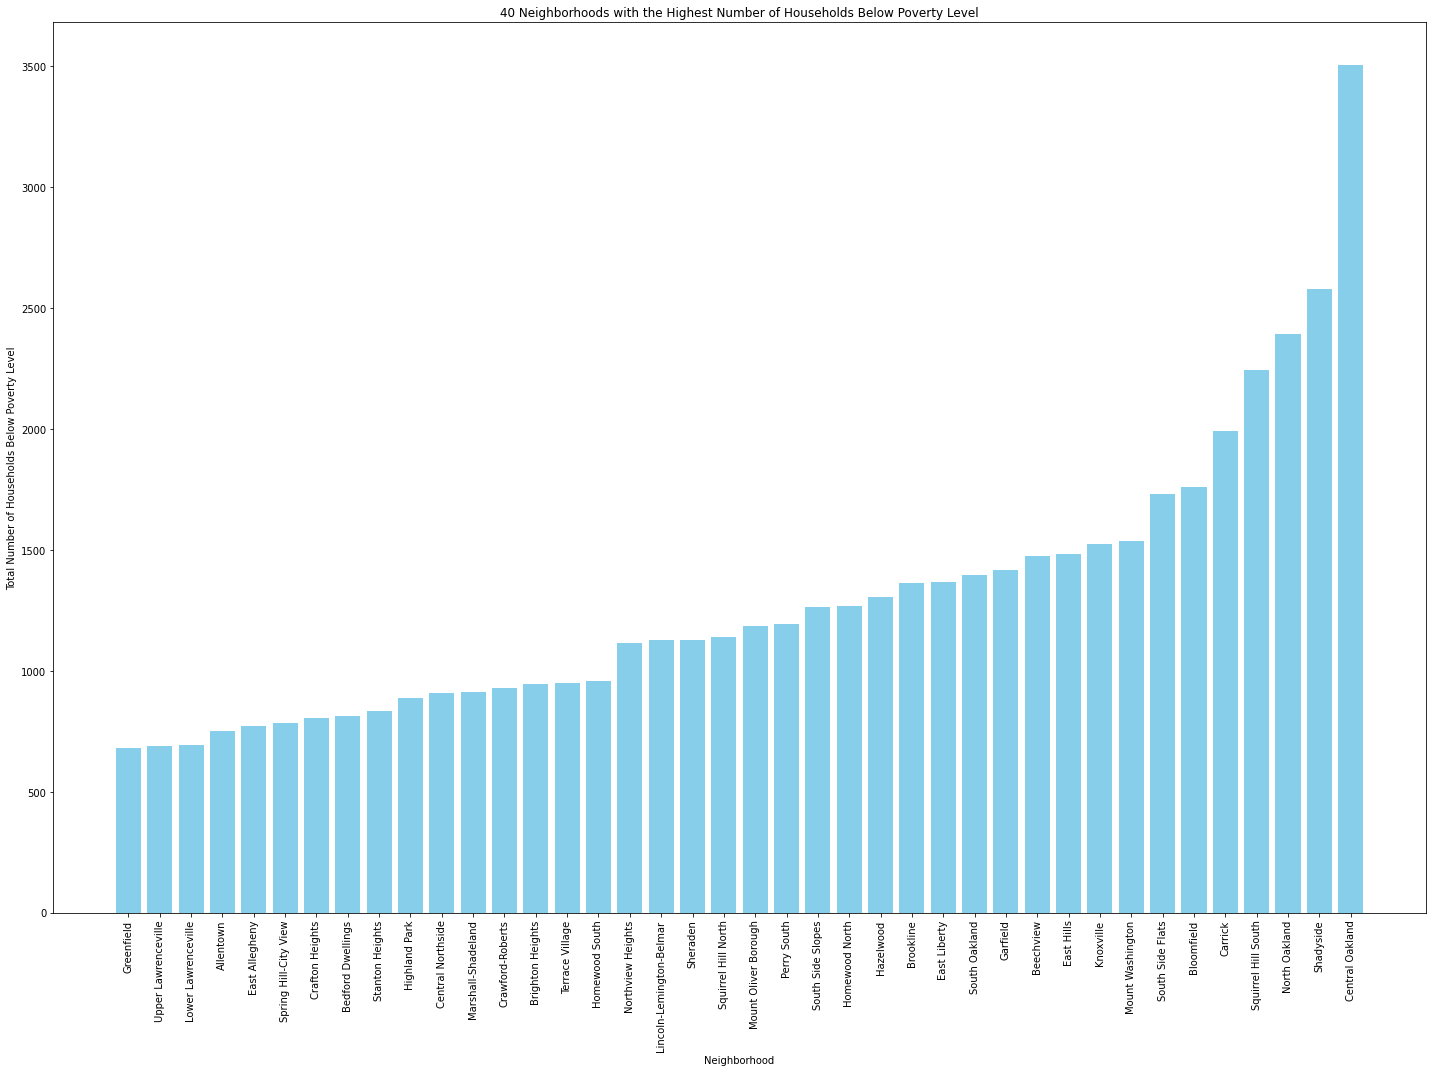

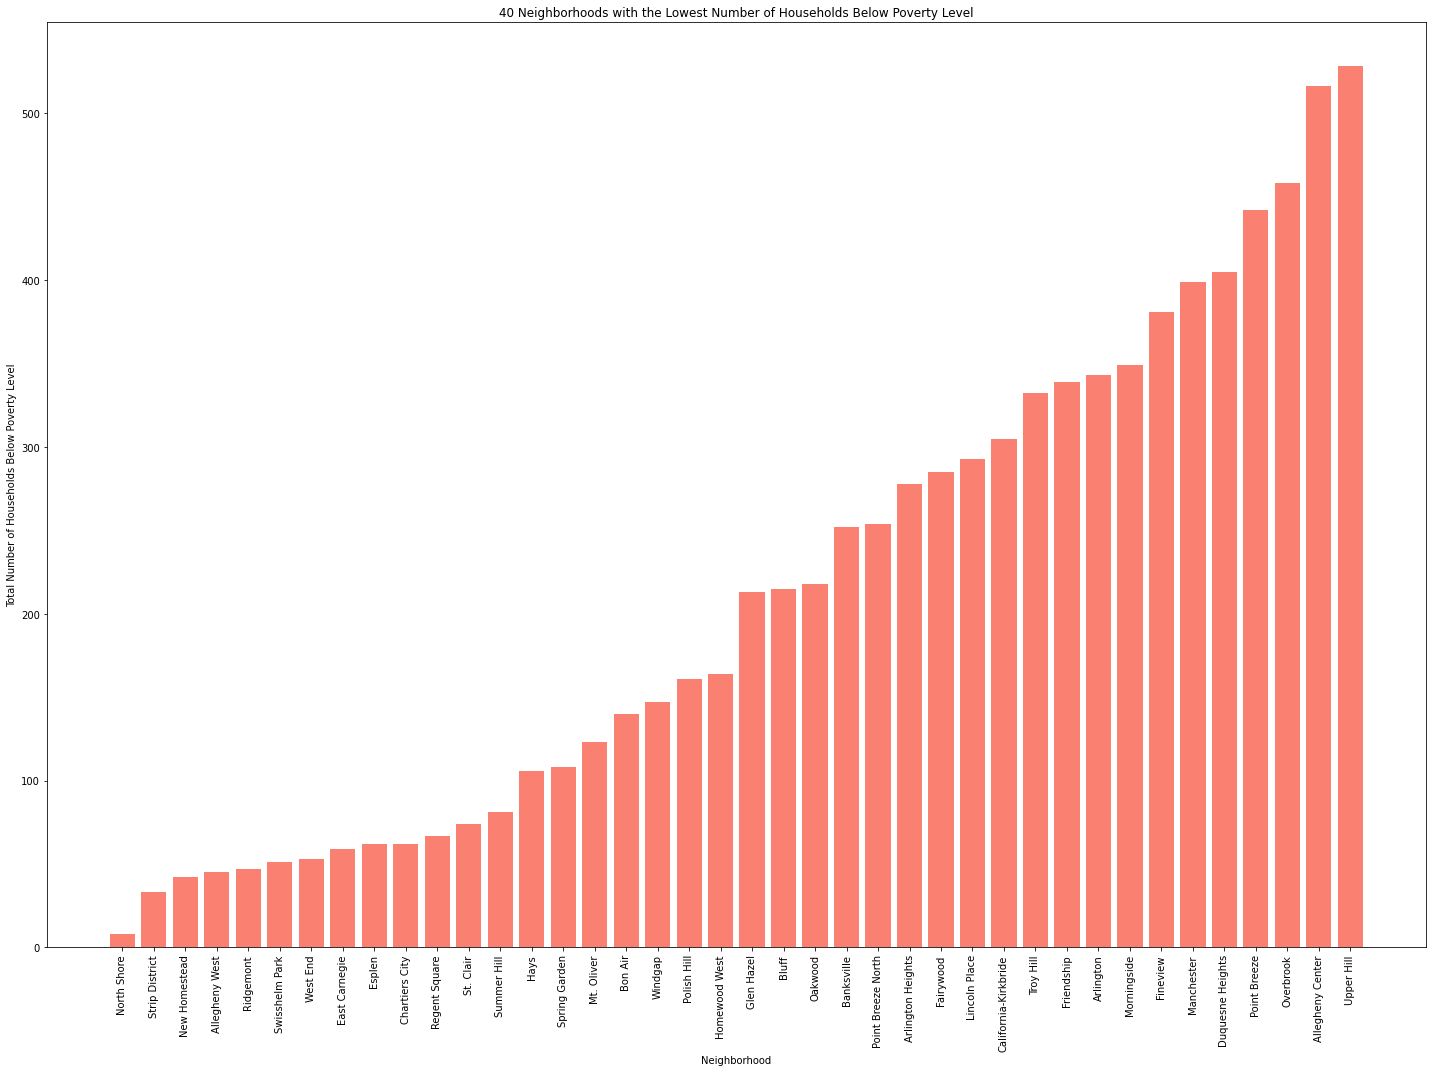

In [31]:
import pandas as pd
import matplotlib.pyplot as plt

neighborhood_totals_below_poverty = {}

# Iterate over the rows of the DataFrame, and pairing each neighborhood with its respective poverty level
for index, row in df.iterrows():
    neighborhood = row['Neighborhood']
    below_poverty_total = row['Estimate; Income in the past 12 months below poverty level:']
    neighborhood_totals_below_poverty[neighborhood] = below_poverty_total

# Convert the dictionary to a DataFrame
df_below_poverty_totals = pd.DataFrame.from_dict(neighborhood_totals_below_poverty, orient='index', columns=['Total Below Poverty Level'])

# Filter out neighborhoods with zero entries
df_below_poverty_totals = df_below_poverty_totals[df_below_poverty_totals['Total Below Poverty Level'] > 0]

# Sort the DataFrame by the totals
df_below_poverty_totals_sorted = df_below_poverty_totals.sort_values(by='Total Below Poverty Level')

# Select the bottom 50 neighborhoods and top 50 neighborhoods
bottom_40_neighborhoods_below_poverty = df_below_poverty_totals_sorted.head(40)
top_40_neighborhoods_below_poverty = df_below_poverty_totals_sorted.tail(40)

# Plotting the bar plots for the top 50 neighborhoods
plt.figure(figsize=(20, 15))
plt.bar(top_40_neighborhoods_below_poverty.index, top_40_neighborhoods_below_poverty['Total Below Poverty Level'], color='skyblue')
plt.title('40 Neighborhoods with the Highest Number of Households Below Poverty Level')
plt.xlabel('Neighborhood')
plt.ylabel('Total Number of Households Below Poverty Level')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plotting the bar plots for the bottom 40 neighborhoods
plt.figure(figsize=(20, 15))
plt.bar(bottom_40_neighborhoods_below_poverty.index, bottom_40_neighborhoods_below_poverty['Total Below Poverty Level'], color='salmon')
plt.title('40 Neighborhoods with the Lowest Number of Households Below Poverty Level')
plt.xlabel('Neighborhood')
plt.ylabel('Total Number of Households Below Poverty Level')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

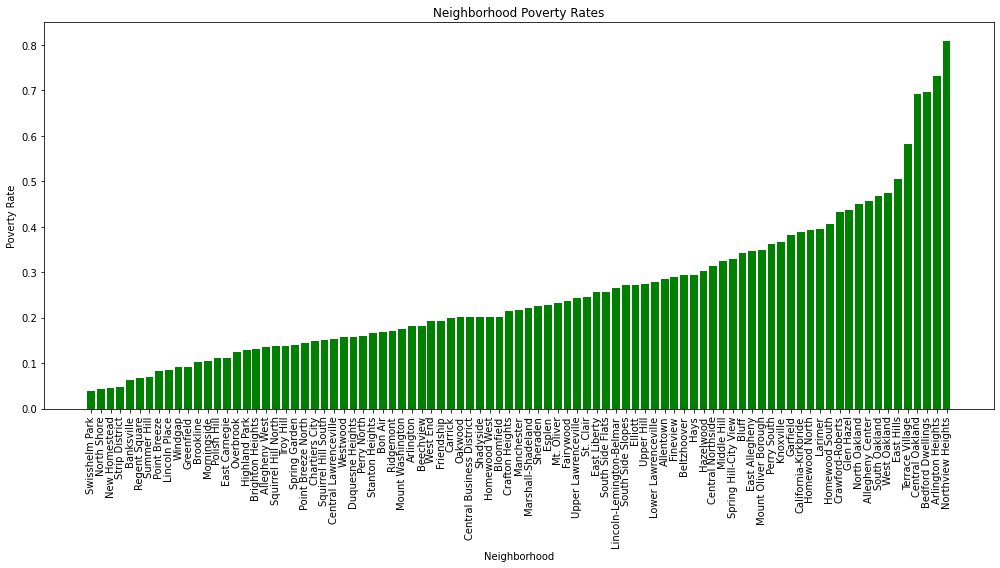

In [32]:
import pandas as pd
import matplotlib.pyplot as plt

data = []

# Iterate over the neighborhoods in the dictionary, calculating the poverty rate 
for neighborhood, below_poverty_total in neighborhood_totals_below_poverty.items():
    # Get the total households for the neighborhood
    total_households = df.loc[df['Neighborhood'] == neighborhood, 'Estimate; Total:'].iloc[0]
    
    # Calculate the poverty rate
    if below_poverty_total > 0:  # Filter out zero values
        poverty_rate = below_poverty_total / total_households
    else:
        continue

    # Append the data to the list
    data.append({'Neighborhood': neighborhood, 'Below Poverty Total': below_poverty_total, 'Total Households': total_households, 'Poverty Rate': poverty_rate})

# Create a DataFrame from the list of data
df_poverty_rates = pd.DataFrame(data)

# Sort the DataFrame by the 'Poverty Rate' column
df_sorted = df_poverty_rates.sort_values(by='Poverty Rate')

# Plotting all neighborhood poverty levels in one bar chart
plt.figure(figsize=(14, 8))

plt.bar(df_sorted['Neighborhood'], df_sorted['Poverty Rate'], color='green')

plt.title('Neighborhood Poverty Rates')
plt.xlabel('Neighborhood')
plt.ylabel('Poverty Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The above graphic represents the total amount of households in poverty within each Pittsburgh neighborhood by the total number of households to generate a more unbiased reflection of poverty in each area. This standardized representation of poverty is not affected by population and can be used to compare neighborhoods to one another.

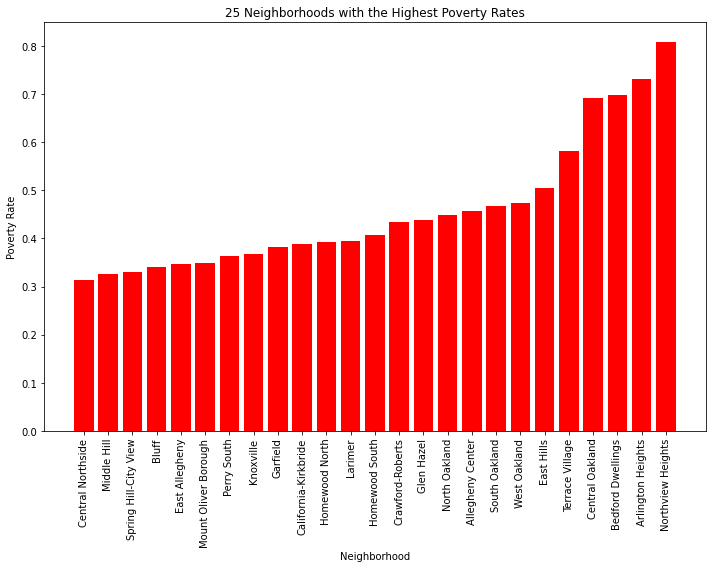

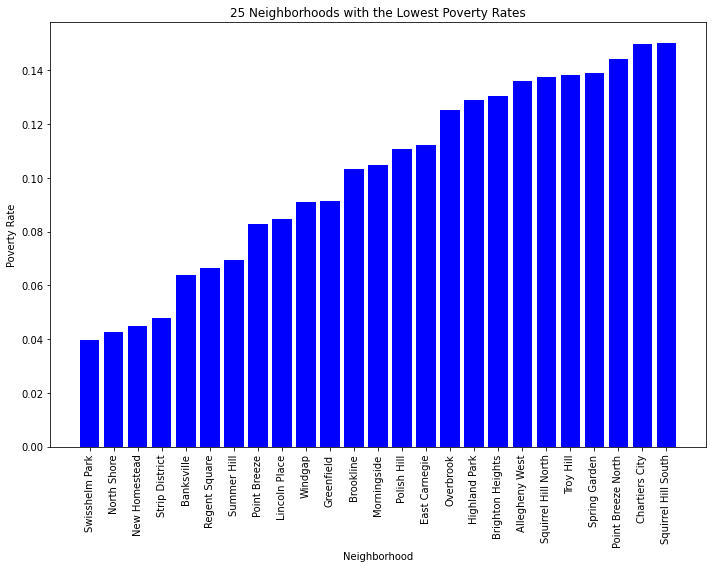

In [33]:
import pandas as pd
import matplotlib.pyplot as plt

data = []

# Iterate over the neighborhoods in the dictionary, calculating the poverty rate 
for neighborhood, below_poverty_total in neighborhood_totals_below_poverty.items():
    # Get the total households for the neighborhood
    total_households = df.loc[df['Neighborhood'] == neighborhood, 'Estimate; Total:'].iloc[0]
    
    # Calculate the poverty rate
    if below_poverty_total > 0:  # Filter out zero values
        poverty_rate = below_poverty_total / total_households
    else:
        continue

    # Filter out neighborhoods with poverty rates below zero or above 1
    if 0 <= poverty_rate <= 1:
        # Append the data to the list
        data.append({'Neighborhood': neighborhood, 'Below Poverty Total': below_poverty_total, 'Total Households': total_households, 'Poverty Rate': poverty_rate})

# Create a DataFrame from the list of data
df_poverty_rates_filtered = pd.DataFrame(data)

# Sort the DataFrame by the 'Poverty Rate' column
df_sorted = df_poverty_rates_filtered.sort_values(by='Poverty Rate')

# Select the top 25 highest and lowest poverty rates
top_25_highest = df_sorted.tail(25)
top_25_lowest = df_sorted.head(25)

# Plotting the bar plots for the top 25 highest poverty rates
plt.figure(figsize=(10, 8))
plt.bar(top_25_highest['Neighborhood'], top_25_highest['Poverty Rate'], color='red')
plt.title('25 Neighborhoods with the Highest Poverty Rates')
plt.xlabel('Neighborhood')
plt.ylabel('Poverty Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Plotting the bar plots for the top 25 lowest poverty rates
plt.figure(figsize=(10, 8))
plt.bar(top_25_lowest['Neighborhood'], top_25_lowest['Poverty Rate'], color='blue')
plt.title('25 Neighborhoods with the Lowest Poverty Rates')
plt.xlabel('Neighborhood')
plt.ylabel('Poverty Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

A very liveable neighborhood could be one that has a low poverty rate and a less liveable place could be one with a high poverty rate. The above graphics are the 25 highest and lowest poverty rates. Swisshelm Park has the lowest poverty rate.

## Metric 3: Pittsburgh Police Arrests by Neighborhood

#### by Tom Neill-DeMarco

Import pandas and initialize the Arrests dataset with pandas

In [34]:
import pandas as pd
df = pd.read_csv('Arrests.csv')

Group arrests by the neighborhood they occurred in, the "INCIDENTNEIGHBORHOOD" column, and plot the top 50 neighborhoods with the highest and lowest number of arrests respectively

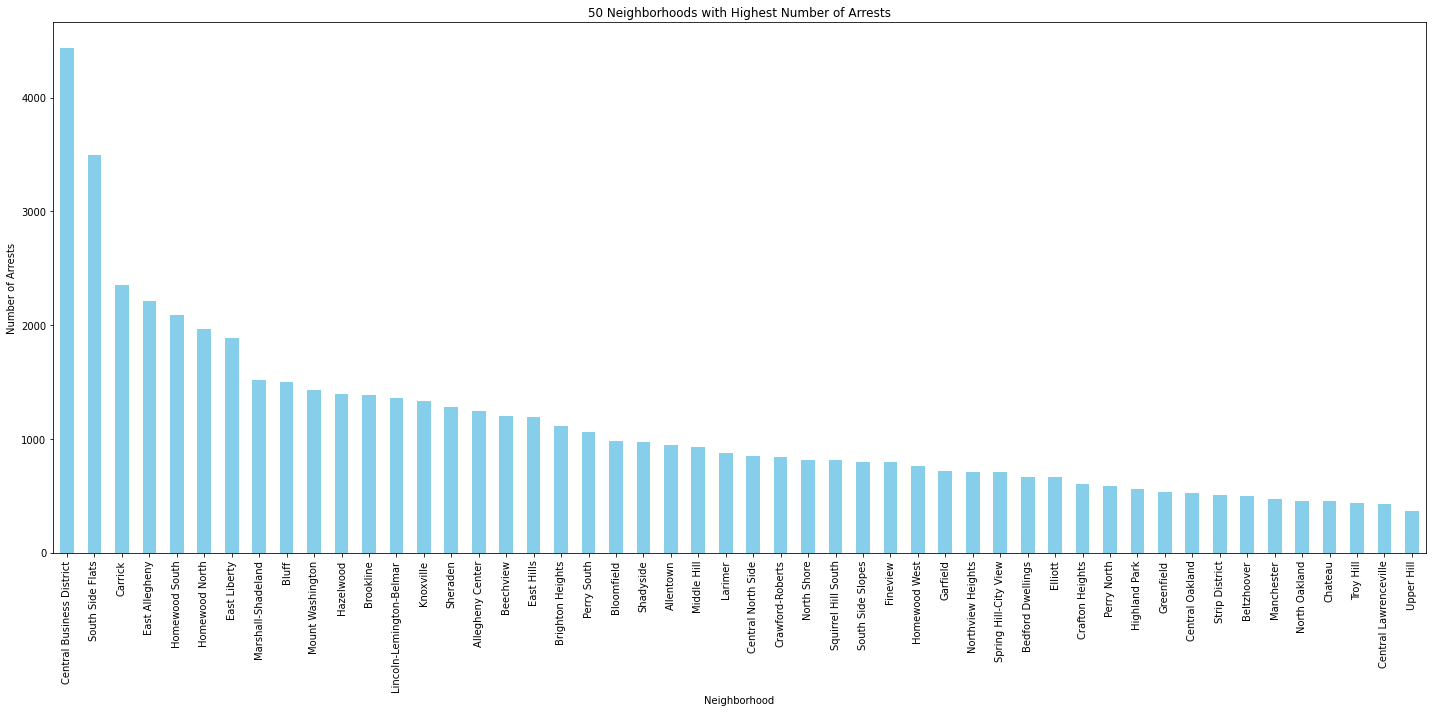

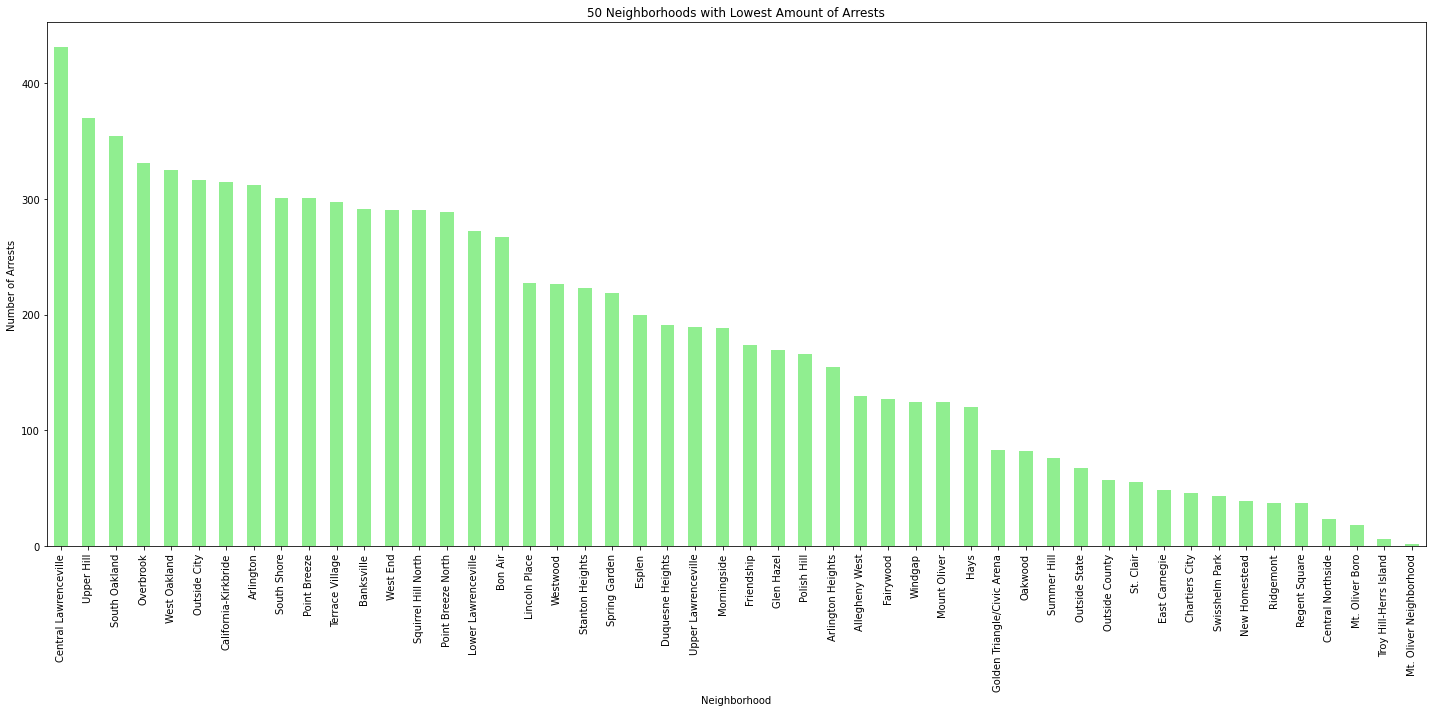

In [35]:
import pandas as pd
import matplotlib.pyplot as plt

# Group by neighborhood and count the number of arrests
arrests_by_neighborhood = df.groupby('INCIDENTNEIGHBORHOOD').size().sort_values(ascending=False)

# Select top 50 neighborhoods with most arrests and  bottom 50 neighborhoods with least arrests
top_50_neighborhoods = arrests_by_neighborhood.head(50)
bottom_50_neighborhoods = arrests_by_neighborhood.tail(50)

# Create a figure for the top neighborhoods
plt.figure(figsize=(20, 10))
top_50_neighborhoods.plot(kind='bar', color='skyblue')
plt.title('50 Neighborhoods with Highest Number of Arrests')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Arrests')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

# Create a figure for the bottom neighborhoods
plt.figure(figsize=(20, 10))
bottom_50_neighborhoods.plot(kind='bar', color='lightgreen')
plt.title('50 Neighborhoods with Lowest Amount of Arrests')
plt.xlabel('Neighborhood')
plt.ylabel('Number of Arrests')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

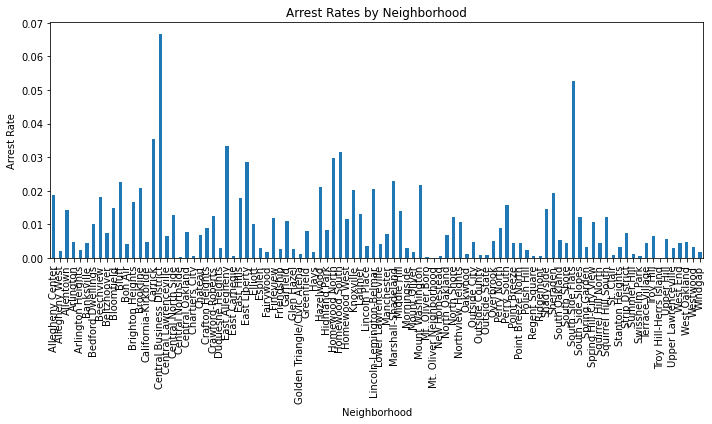

In [36]:
import pandas as pd
import matplotlib.pyplot as plt

arrests_by_neighborhood = df.groupby('INCIDENTNEIGHBORHOOD').size()
total_arrests = df.shape[0]

# Calculate arrest rates
arrest_rates = arrests_by_neighborhood / total_arrests

# Plotting
plt.figure(figsize=(10, 6))
arrest_rates.plot(kind='bar')
plt.title('Arrest Rates by Neighborhood')
plt.xlabel('Neighborhood')
plt.ylabel('Arrest Rate')
plt.xticks(rotation=90)
plt.tight_layout()
plt.show()

The above graph represents each neighborhoods contribution to the total amount of arrests in Pittsburgh last year. Each neighborhoods amount of arrests was divided by the total amount of arrests in Pittsburgh to produce a proportion. Neighborhoods can be compared by their percentage of total arrests. Downtown and south side appear to be notable outliers.

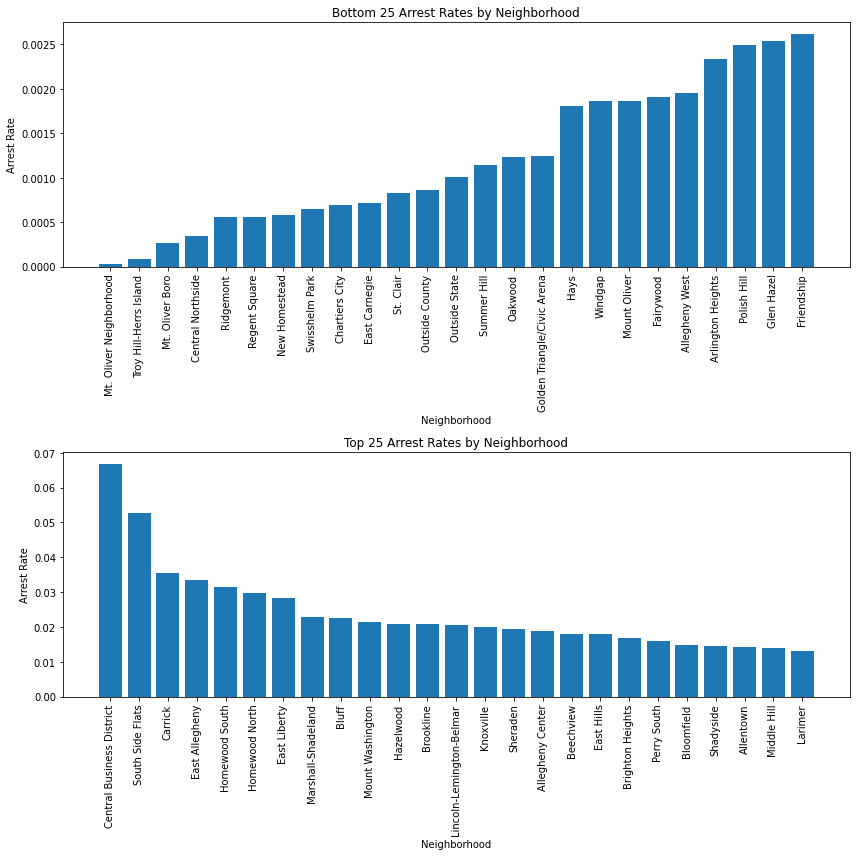

In [37]:
import pandas as pd
import matplotlib.pyplot as plt

arrests_by_neighborhood = df.groupby('INCIDENTNEIGHBORHOOD').size()
total_arrests = df.shape[0]

# Calculate arrest rates
arrest_rates = arrests_by_neighborhood / total_arrests

# Sort arrest rates in ascending order (lowest 25)
lowest_25 = arrest_rates.sort_values().head(25)

# Sort arrest rates in descending order (top 25)
top_25 = arrest_rates.sort_values(ascending=False).head(25)

# Plotting
fig, axes = plt.subplots(2, 1, figsize=(12, 12))

# Plot for lowest 25 arrest rates
axes[0].bar(lowest_25.index, lowest_25.values)
axes[0].set_title('Bottom 25 Arrest Rates by Neighborhood')
axes[0].set_xlabel('Neighborhood')
axes[0].set_ylabel('Arrest Rate')
axes[0].tick_params(axis='x', rotation=90)

# Plot for top 25 arrest rates
axes[1].bar(top_25.index, top_25.values)
axes[1].set_title('Top 25 Arrest Rates by Neighborhood')
axes[1].set_xlabel('Neighborhood')
axes[1].set_ylabel('Arrest Rate')
axes[1].tick_params(axis='x', rotation=90)

plt.tight_layout()
plt.show()

The most livable areas of Pittsburgh could be the ones with the lowest arrest proportion, reflecting it is a safe area. This would be Mt. Oliver Neighborhood.

## Metric Calculation

#### by Isaiah Henck

For our metric, we did a simple ranking system across the three submetrics. The neighborhoods were ranked within each individual metric, and the neighborhood with the best ranking performance within each submetric is the winner

In [42]:
import pandas as pd
df = pd.read_csv('Arrests.csv')
df2 = pd.read_csv('Poverty.csv')
arrests_by_neighborhood = df.groupby('INCIDENTNEIGHBORHOOD').size().sort_values(ascending=False)

In [43]:
import pandas as pd
import matplotlib.pyplot as plt

neighborhood_below_poverty_totals = {}

for index, row in df2.iterrows():
    neighborhood = row['Neighborhood']
    below_poverty_total = row['Estimate; Income in the past 12 months below poverty level:']
    neighborhood_below_poverty_totals[neighborhood] = below_poverty_total
    
sorted_dict = {k: v for k, v in sorted(neighborhood_below_poverty_totals.items(), key=lambda item: item[1], reverse=False)}

In [46]:
import math
hoods_rank = pd.DataFrame(columns = [])
hoods_rank["Neighborhoods"] = arrests_by_neighborhood.index.tolist()
hoods_rank["#_arr"] = arrests_by_neighborhood.values.tolist()
hoods_rank["arr_rank"] = [i for i in range(len(hoods_rank["Neighborhoods"]), 0, -1)]


for key in sorted_dict:
    for i, row in hoods_rank.iterrows():
        if key == row["Neighborhoods"]:
            hoods_rank.at[i, "#_pov"] = int(sorted_dict.get(key))
            hoods_rank.at[i, "pov_rank"] = int(next((ii for ii, (key, value) in enumerate(sorted_dict.items()) if key == row["Neighborhoods"]), None)+1)


for jj, nbhmatch in hoods_rank.iterrows():
    for jjj, foods in sort_tot.iterrows():
        if (foods["Neighborhood"] == nbhmatch["Neighborhoods"]):
            hoods_rank.at[jjj, "#_foo"] = foods["total"]
            


food_rank_list = hoods_rank["#_foo"].tolist()
filtered_list = list(filter(lambda x:not math.isnan(x), food_rank_list))
filtered_list.sort()

for ind, search in hoods_rank.iterrows():
    if search["#_foo"] in filtered_list:
        hoods_rank.at[ind, "foo_rank"] = filtered_list.index(search["#_foo"])+1
    else:
        continue
        
hoods_rank["FINAL_SCORE"] = hoods_rank["arr_rank"] + hoods_rank["foo_rank"] + hoods_rank["foo_rank"]
pd.set_option('display.max_rows', None)  # Show all rows
pd.set_option('display.max_columns', None)  # Show all columns
print(hoods_rank.sort_values("FINAL_SCORE").head(20))

          Neighborhoods  #_arr  arr_rank   #_pov  pov_rank    #_foo  foo_rank  \
87            St. Clair     55        11    74.0      14.0   6485.0       4.0   
84          Summer Hill     76        14    81.0      15.0   8736.0       6.0   
76    Arlington Heights    155        22   278.0      28.0   1455.0       2.0   
70     Duquesne Heights    191        28   405.0      38.0   6485.0       4.0   
73           Friendship    174        25   339.0      33.0  10448.0       9.0   
50        South Oakland    354        48  1397.0      79.0    895.0       1.0   
58      Terrace Village    297        40   948.0      66.0   9134.0       7.0   
79              Windgap    124        19   147.0      20.0  14855.0      18.0   
89       Chartiers City     46         9    62.0      11.0  16310.0      24.0   
83              Oakwood     82        15   218.0      25.0  16310.0      24.0   
64              Bon Air    267        34   140.0      19.0  14478.0      16.0   
53         Outside City    3

## The winner was St. Clair!

### St. Clair ranked:<br>
### **#11** in neighborhoods with the least arrests
### **#14** in neighborhoods with the least poverty
### and **#4** in neighborhood with the least food inspections violations

# Conclusion

**Isaiah:**<br>
My family lives not far from St. Clair, and I'm not too surprised by the results. It is a very small township that is pretty out of the way&ndash;most people near or in it are commuting or driving by. With the small population, it isn't surprising that not much crime is occurring within the township. Additionally, there aren't too many places to eat in the neighborhood&ndash;at least, not anymore&ndash;so keeping a low food violations count is relatively easy to regulate. 

**Tom:**<br>
By using our ranking system, St. Clair appears to be the best neighborhood in Pittsburgh in terms of his liveability. It has the best overall ranking resulting from the combination of low number of arrests, food violations, and number of households below the poverty line.